#What Are Transformer Models?

A transformer is a type of artificial intelligence model that learns to understand and generate human-like text by analyzing patterns in large amounts of text data.

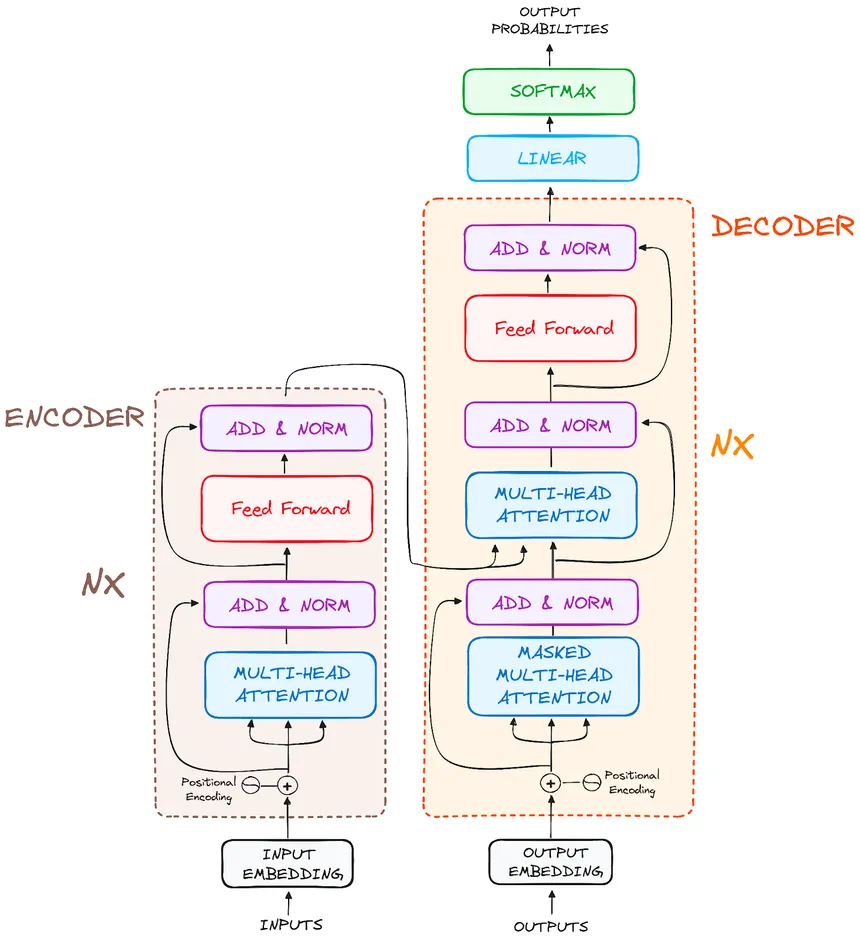

##Stones of Transformer

1. Input embeddings
2. Positional encoding
3. Multi-head attention
4. Layer normalization and residual connections
5. Feedforward neural networks
6. Stacked layers
7. Output layer
8. Training
9. Inference


###Test Trasnformer
1. Tokenizer
2. Loading Dataset
3. Validation Loop
4. Training Loop
5. conclusion

###IMP **Modules**
1. torch (PyTorch)
2. torch.nn (For neural networks)
3. torch.utils.data
4. math

#**Let's Ignite**

[Attention Is All You Need](https://papers.neurips.cc/paper/7181-attention-is-all-you-need.pdf)

Parameters used in Paper:


*   d_model = 512 (dimention of embedding in model)
*   seq_len = x.shape[1]
*   h=8
*   d_q = query
*   d_k = key
*   d_v = value
*   d_k = d_v = d_model//h = 64
*   dff = 2048



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import numpy as np


In [ ]:
print("Number of GPU: ", torch.cuda.device_count())
# print("GPU Name: ", torch.cuda.get_device_name())

Number of GPU:  0


In [ ]:
# To check the device that we are using cpu or gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## **Input Embedding**

For each token, the Transformer maintains a vector called an “embedding”. An embedding aims to capture the semantic meaning of the token - similar tokens have similar embeddings.

The encoder begins by converting input tokens - words or subwords - into vectors using embedding layers. These embeddings capture the semantic meaning of the tokens and convert them into numerical vectors.

All the encoders receive a list of vectors, each of size 512 [**d_model size**].

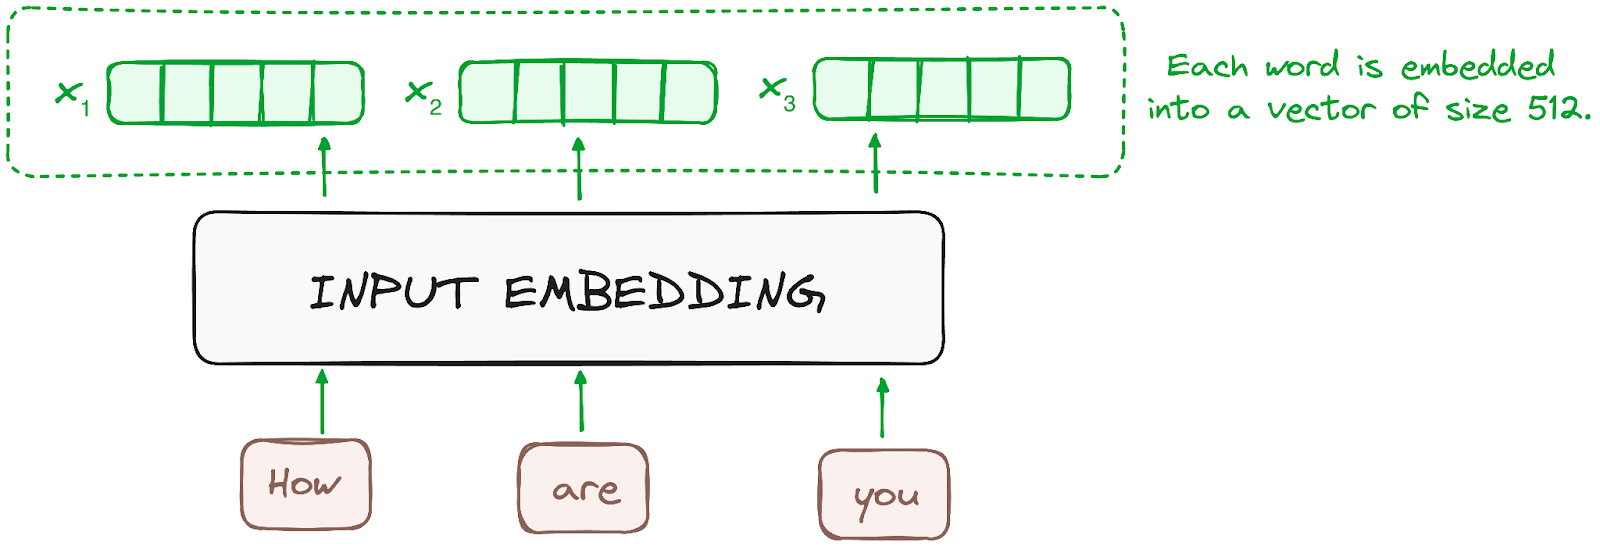

<video width="560" height="315" loop controls>
  <source src="https://prvnsmpth.github.io/animated-transformer/_app/immutable/assets/WordEmbeddings.bfc20520.mp4" type="video/mp4" autoplay loop>
</video>

In [ ]:
class InputEmbedding(nn.Module):
  def __init__(self, d_model:int, vocab_size:int):
    super().__init__()
    self.d_model=d_model
    self.vocab_size=vocab_size
    self.embedding=nn.Embedding(vocab_size, d_model)

  def forward(self,x):
    return self.embedding(x)+ math.sqrt(self.d_model)

max_sequence_length = xxx

embedding_dim = 512

##Positional Encoding
Since Transformers do not have a recurrence mechanism like RNNs, they use positional encodings added to the input embeddings to provide information about the position of each token in the sequence. This allows them to understand the position of each word within the sentence.

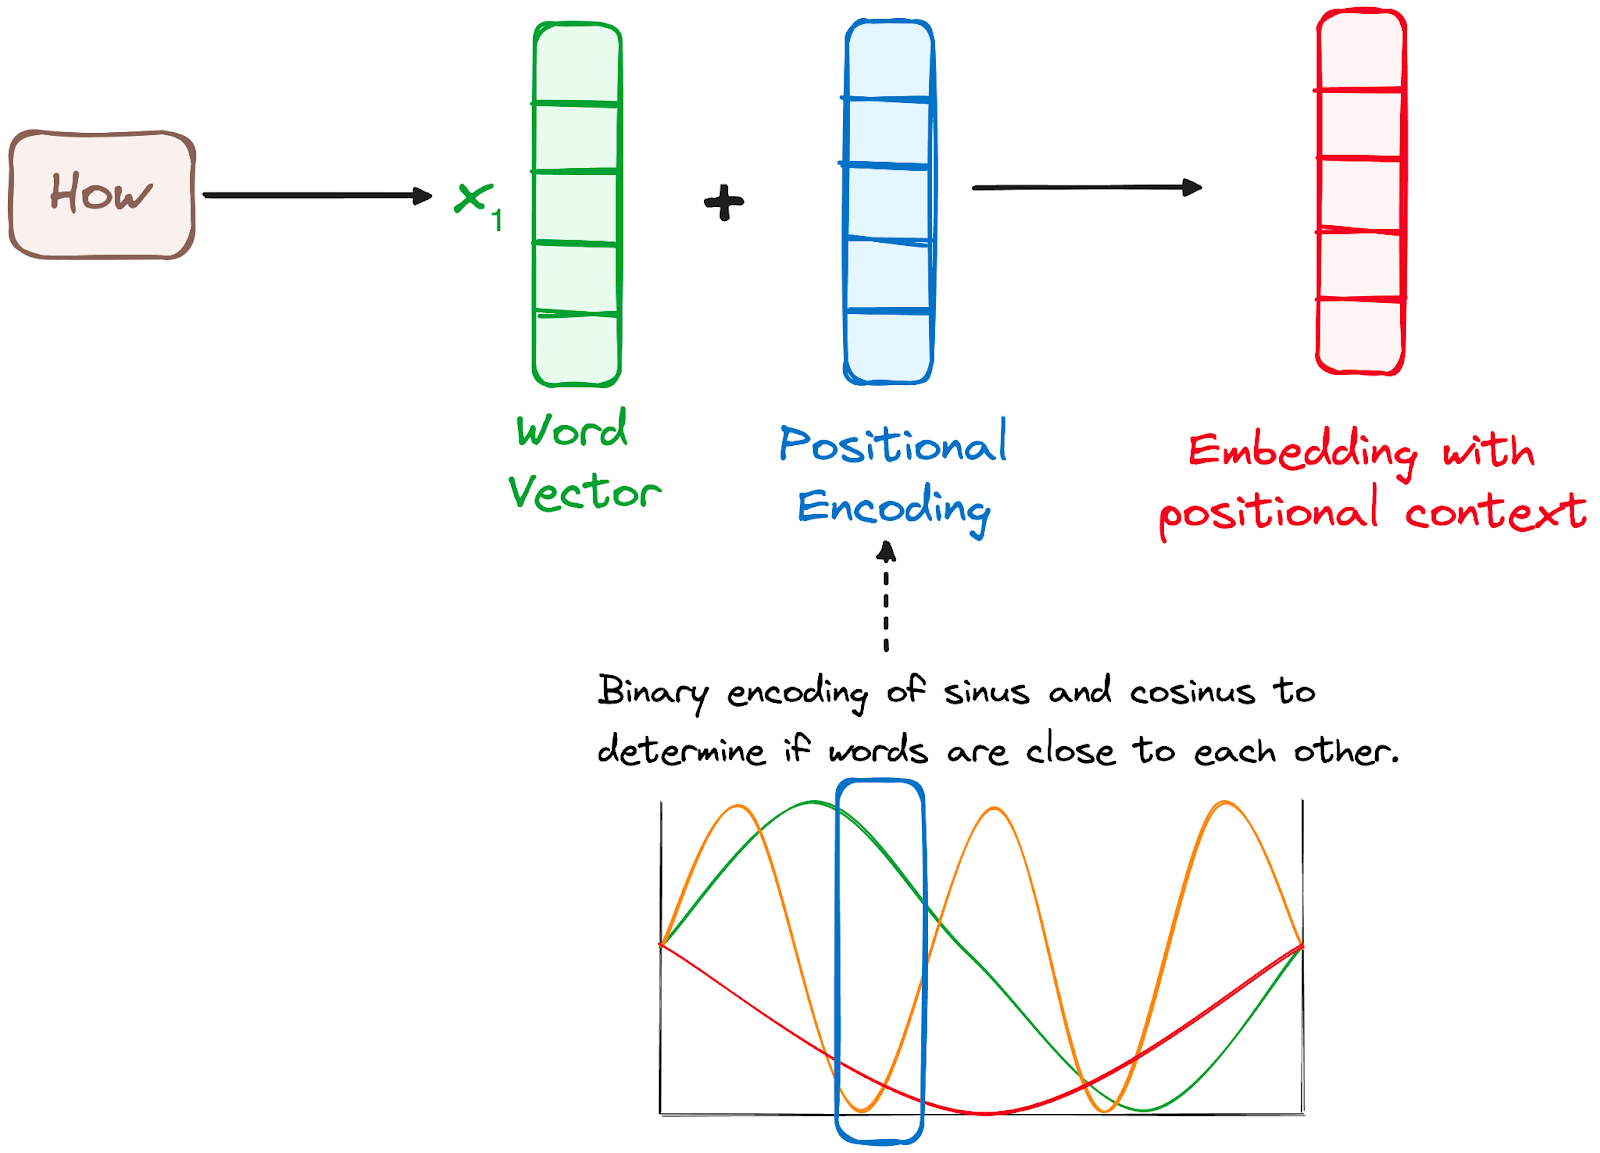

<video width="560" height="315" loop controls>
  <source src="https://prvnsmpth.github.io/animated-transformer/_app/immutable/assets/PreparingEmbeddings.12d15466.mp4" type="video/mp4" autoplay loop>
</video>

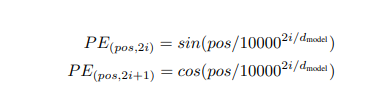

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class PositionalEncoding(nn.Module):

  def __init__(self, d_model:int, seq_len:int, dropout:float):

    super().__init__()
    self.d_model=d_model
    self.seq_len=seq_len
    self.dropout = nn.Dropout(dropout)

    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) #[seq_len,1]

    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))

     # apply the sin to even position
    pe[:, 0::2] = torch.sin(position * div_term)
    # apply the cos to odd position
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0) # [1, seq_len,d_model] to handel in batches

    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + (self.pe[:,:x.shape[1],:]).requires_grad_(False)
    return self.dropout(x)

##MultiHead Attention
the multi-headed attention utilizes a specialized attention mechanism known as self-attention. This approach enables the models to relate each word in the input with other words. For instance, in a given example, the model might learn to connect the word “are” with “you”.

This mechanism allows the encoder to focus on different parts of the input sequence as it processes each token. It computes attention scores based on:

* A query is a vector that represents a specific word or token from the input sequence in the attention mechanism.
* A key is also a vector in the attention mechanism, corresponding to each word or token in the input sequence.
* Each value is associated with a key and is used to construct the output of the attention layer. When a query and a key match well, which basically means that they have a high attention score, the corresponding value is emphasized in the output.

This first Self-Attention module enables the model to capture contextual information from the entire sequence. Instead of performing a single attention function, queries, keys and values are linearly projected h times. On each of these projected versions of queries, keys and values the attention mechanism is performed in parallel, yielding h-dimensional output values.

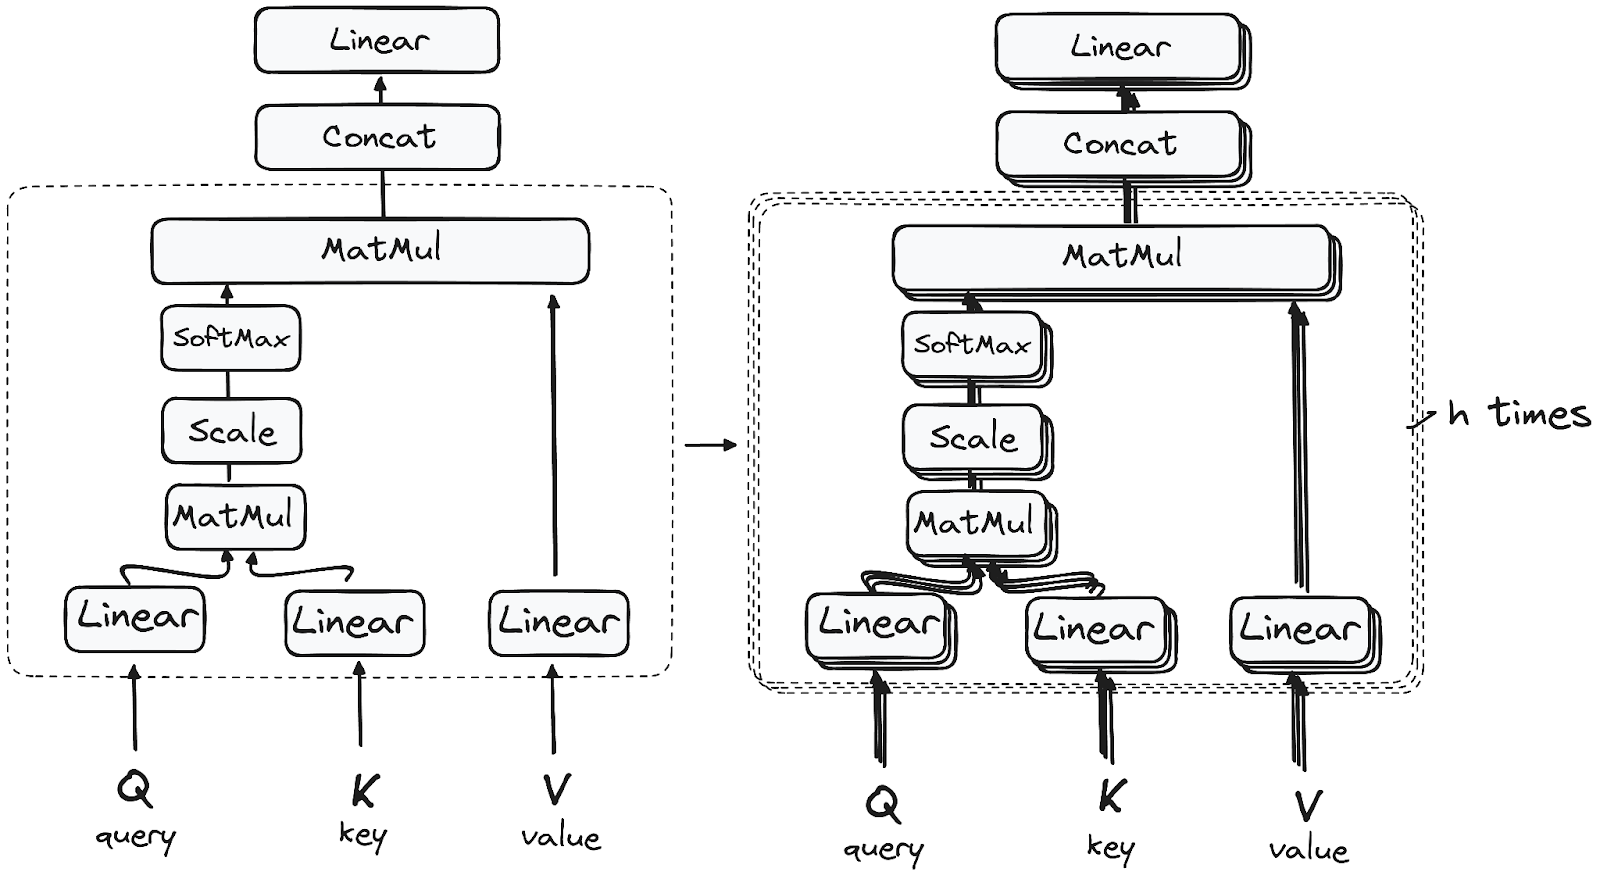

**Queries, keys and values**:

The Transformer then computes three vectors for each of the T vectors (each of row in the T × C matrix from the previous section): “query”, “key” and “value” vectors. This is done by way of three linear transformations (i.e., multiplying with a weight matrix):

<video width="560" height="315" loop controls>
  <source src="https://prvnsmpth.github.io/animated-transformer/_app/immutable/assets/QueryKeyValue.dc88d63e.mp4" type="video/mp4" autoplay loop>
</video>

The weight matrices that produce Q, K, V matrices are all part of θ.


The query, key and value vectors for each token are packed together into T × C matrices, just like the input embedding matrix. These vectors are the primary participants involved in the main event which is coming up shortly: self-attention.

###Matrix Calculation of Self-Attention

The first step is to calculate the Query, Key, and Value matrices. We do that by packing our embeddings into a matrix X, and multiplying it by the weight matrices we’ve trained (WQ, WK, WV).

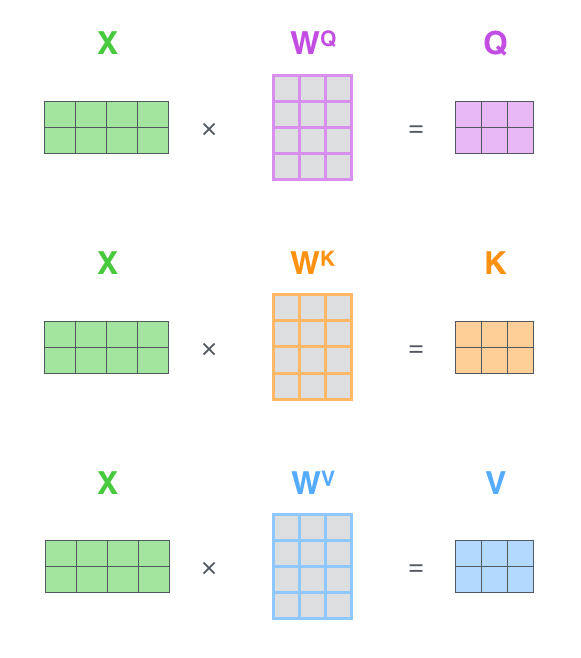


Finally, since we’re dealing with matrices, we can condense steps two through six in one formula to calculate the outputs of the self-attention layer.

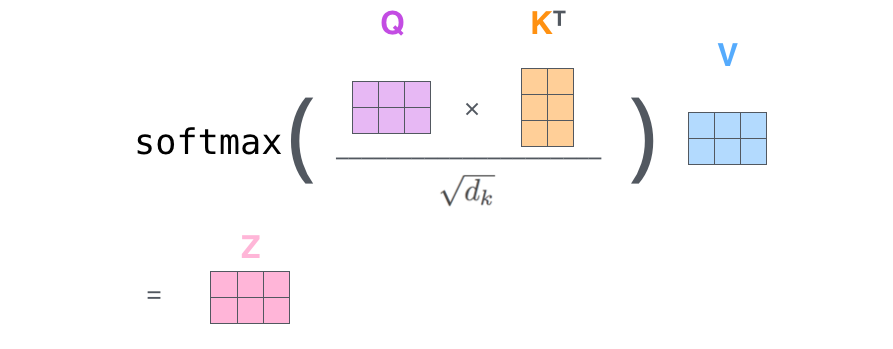

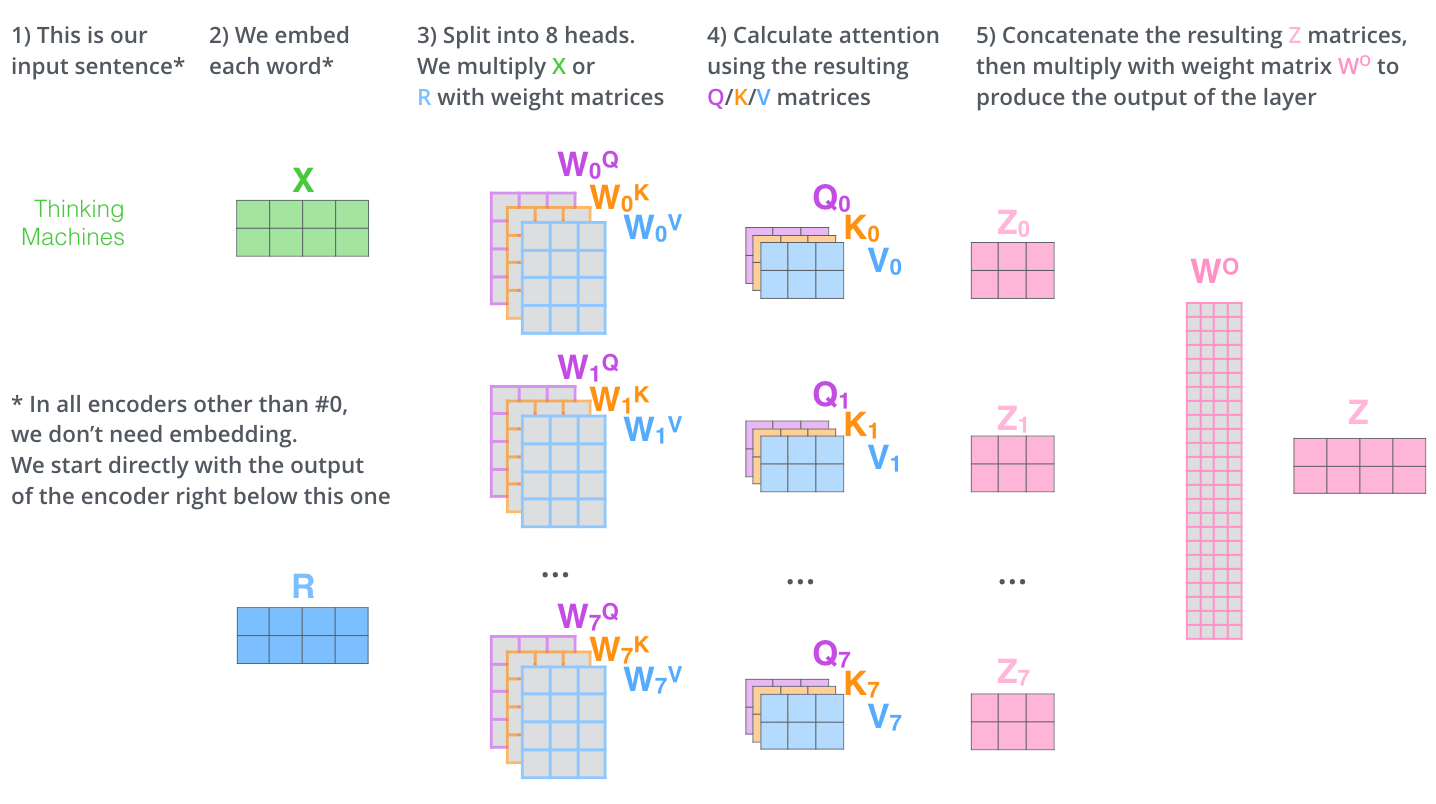

###Masking

The attention score for a token needs to be masked if it occurs earlier in the sequence for a given target token. E.g., in our input phrase: “the robots will bring _____” it makes sense for the token “bring” to pay attention to the token “robots”, but not vice-versa, because a token should not be allowed to look to the future tokens for making a prediction of its next token.

So we hide the upper-right triangle of the square matrix A1, effectively setting the attention score to 0.

We then bring the third actor onto the stage, the Value matrix V:

<video width="560" height="315" loop controls>
  <source src="https://prvnsmpth.github.io/animated-transformer/_app/immutable/assets/SelfAttnPt2.47b1c555.mp4" type="video/mp4" autoplay loop>
</video>

In [ ]:
class MultiHeadAttntionBlock(nn.Module):

  def __init__(self, d_model:int, h:int, dropout:float)->None:
    super().__init__()
    self.d_model=d_model
    self.dropout=nn.Dropout(dropout)
    self.h=h
    assert d_model%h == 0, 'd_model is not divisible by h'
    self.d_k = d_model // h

    self.w_q = nn.Linear(d_model,d_model)
    self.w_k = nn.Linear(d_model,d_model)
    self.w_v = nn.Linear(d_model,d_model)

    self.w_o = nn.Linear(d_model,d_model)

  @staticmethod
  def attention(query, key, value, mask, dropout:nn.Dropout):
    d_k = query.shape[-1]
    attention_scores = torch.matmul(query, key.transpose(-2,-1)) / math.sqrt(d_k)

    # apply mask
    if mask is not None:
      attention_scores.masked_fill_(mask == 0, -1e9)

    # apply softmax
    attention_scores = attention_scores.softmax(dim=-1)

    # apply dropout
    if dropout is not None:
      attention_scores = dropout(attention_scores)

    return torch.matmul(attention_scores, value), attention_scores


  def forward(self, q, k, v, mask):
    query = self.w_q(q)  #[1,seq_len,d_model]
    key = self.w_k(k)
    value = self.w_v(v)

    query = query.view(query.shape[0], query.shape[1], self.h, self.d_k) #[1,seq_len,h,d_k]
    key = key.view(key.shape[0], key.shape[1], self.h, self.d_k)
    value = value.view(value.shape[0], value.shape[1], self.h, self.d_k)

    query = query.transpose(1,2) #[1,h,seq_len,d_k]
    key = key.transpose(1,2)
    value = value.transpose(1,2)

    x, self.attention_scores = MultiHeadAttntionBlock.attention(query, key, value, mask, self.dropout)

    x = x.transpose(1,2).contiguous.view(x.shape, -1, self.h * self.d_k) #[1, seq_len, d_model]

    return self.w_o(x)


##LayerNormalization

Each sub-layer in an encoder layer is followed by a normalization step.
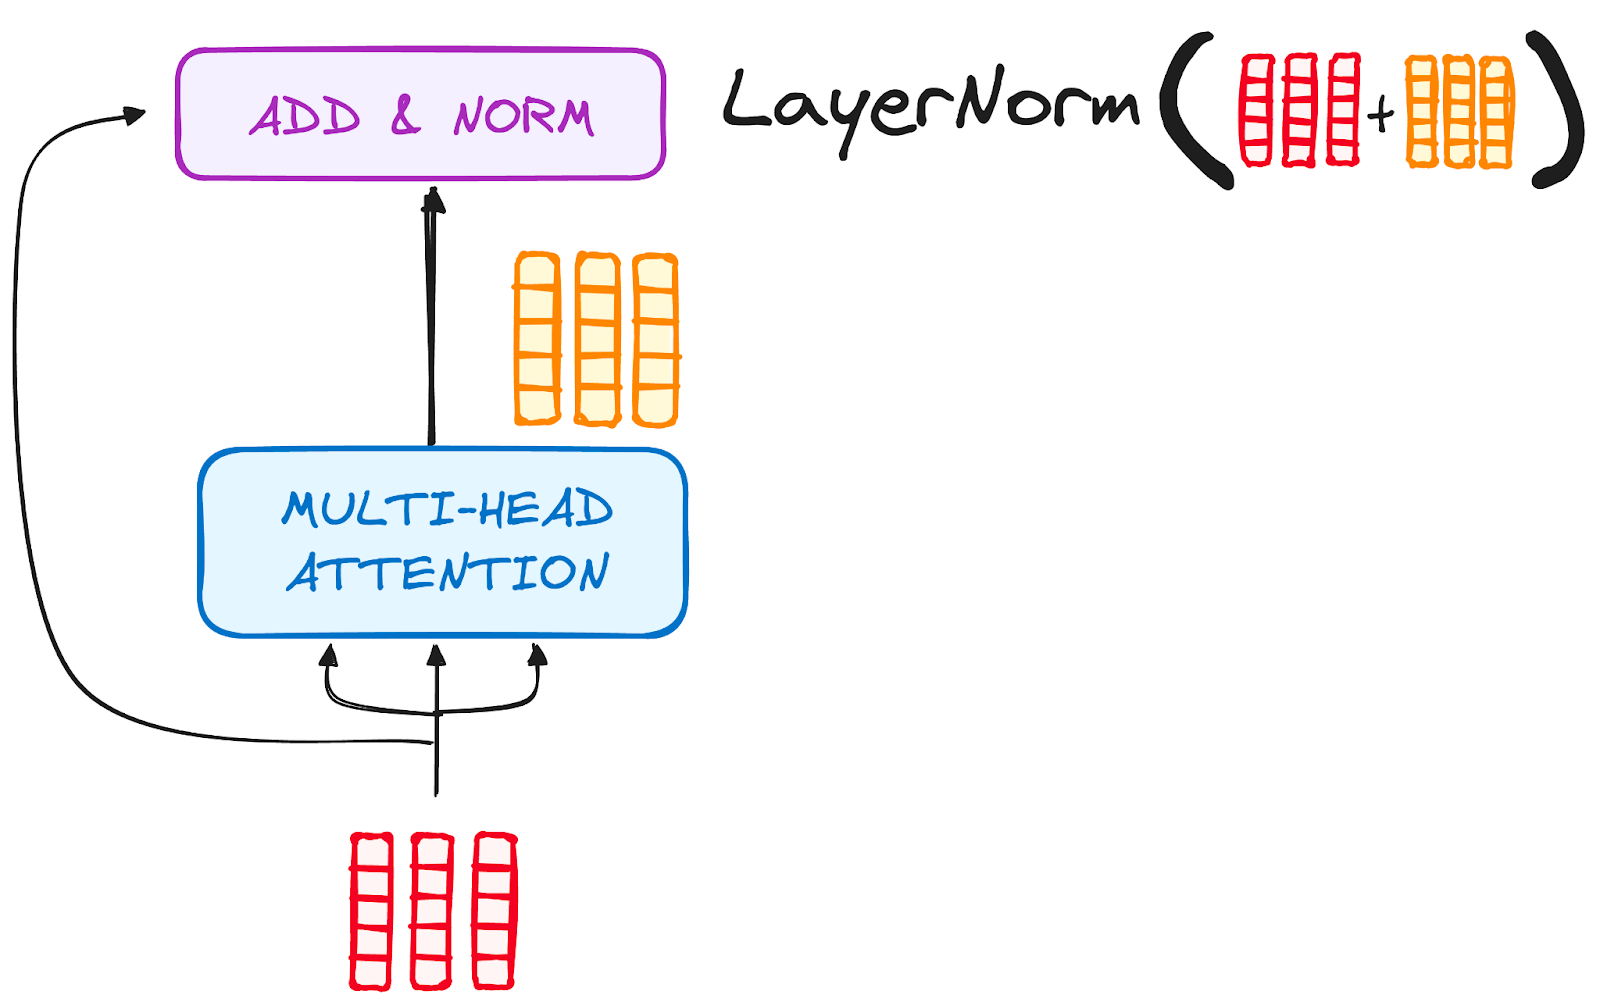



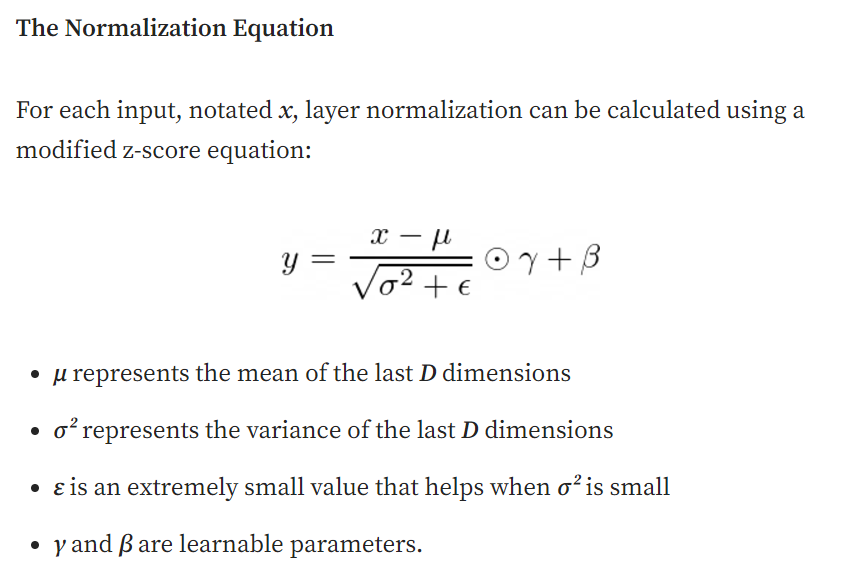

In [ ]:
class LayerNormalization(nn.Module):

  def __init__(self, eps:float=1e-6):
    super().__init__()
    self.eps = eps
    self.alpha = nn.Parameter(torch.ones(1)) # Multiplied
    self.beta = nn.Parameter(torch.zeros(1)) # Added

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.alpha * (x - mean) / (std + self.eps) + self.beta

##Feed Forward Network

The journey of the normalized residual output continues as it navigates through a pointwise feed-forward network, a crucial phase for additional refinement.

Picture this network as a duo of linear layers, with a ReLU activation nestled in between them, acting as a bridge. Once processed, the output embarks on a familiar path: it loops back and merges with the input of the pointwise feed-forward network.

This reunion is followed by another round of normalization, ensuring everything is well-adjusted and in sync for the next steps.
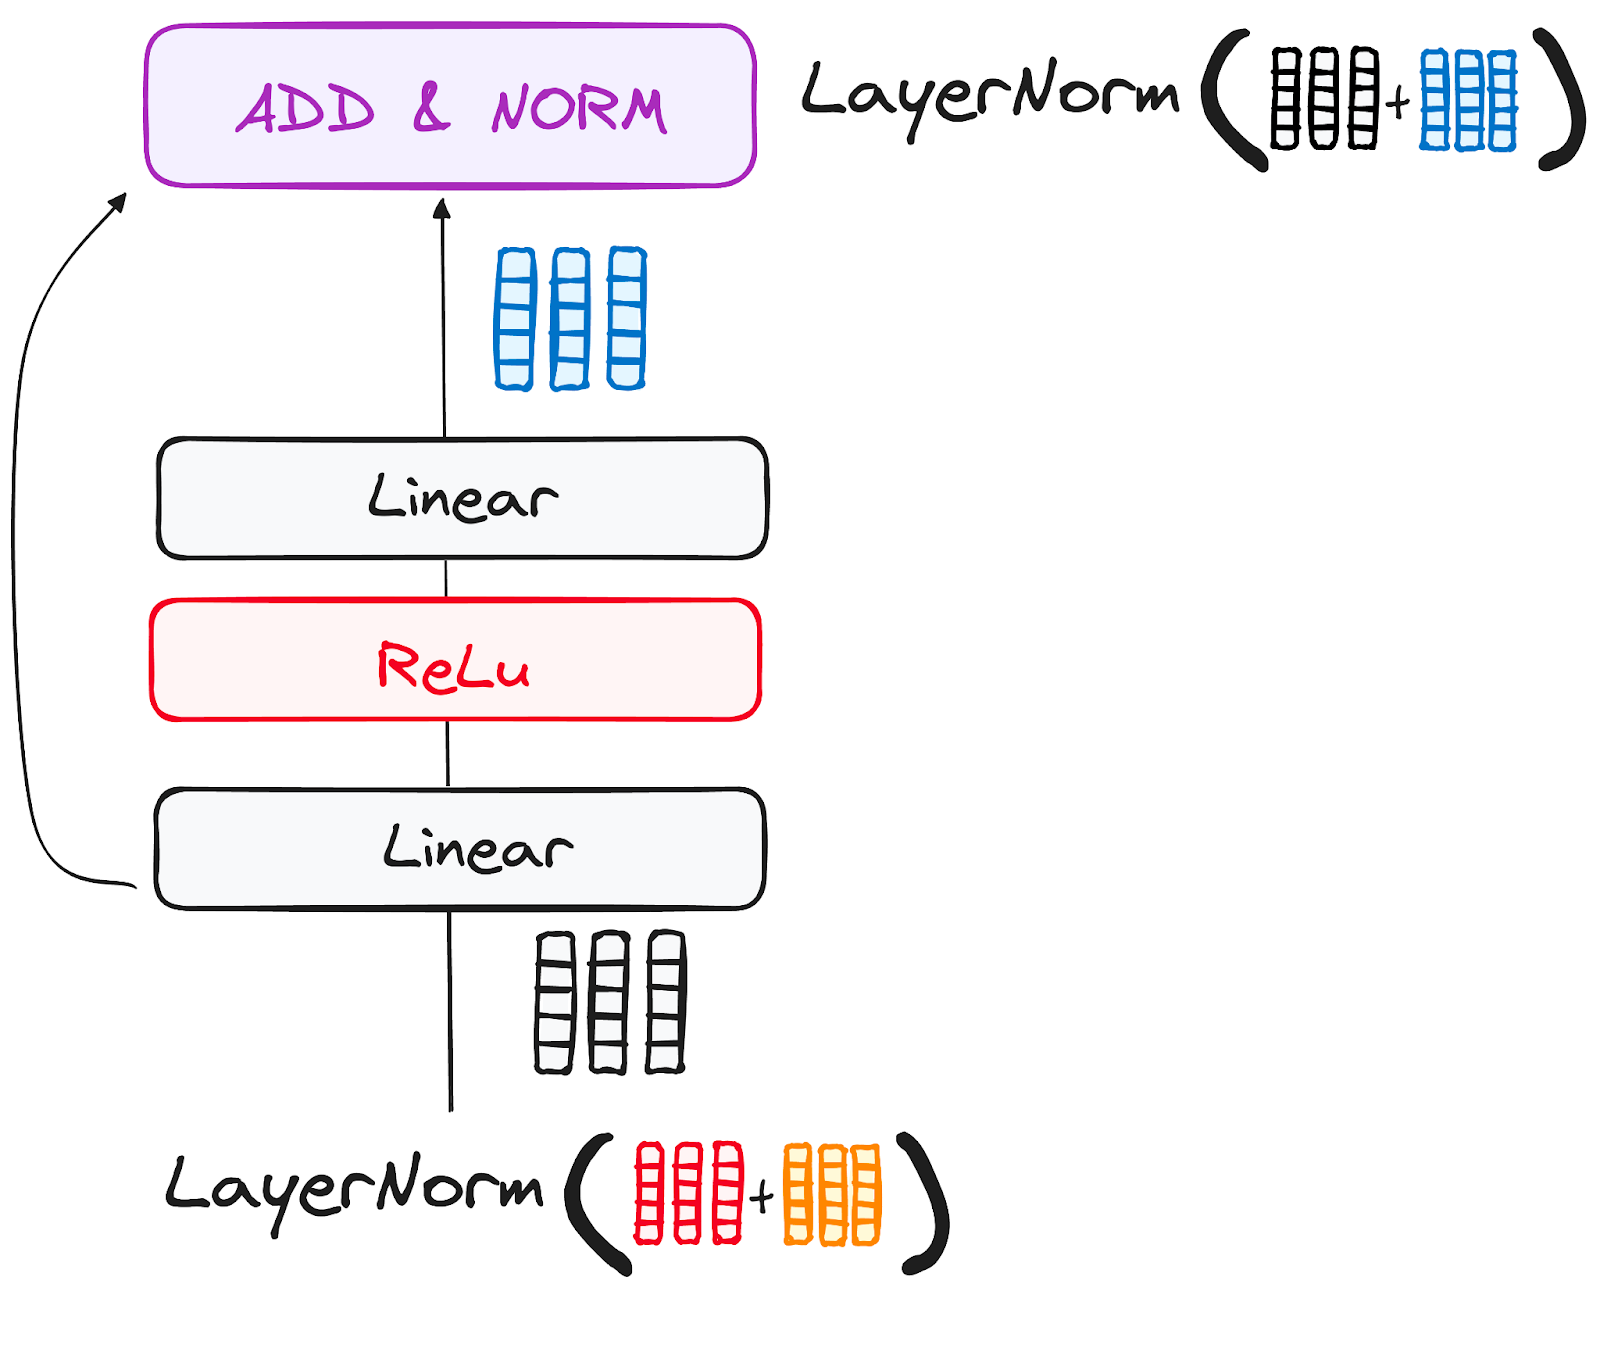


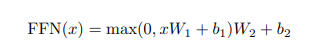

While the linear transformations are the same across different positions, they use different parameters
from layer to layer. Another way of describing this is as two convolutions with kernel size 1.
The dimensionality of input and output is dmodel = 512, and the inner-layer has dimensionality
dff = 2048.

In [ ]:
class FeedForwardBlock(nn.Module):
  def __init__(self, d_model:int, dff:int, dropout:float):
    super().__init__()
    self.linear_1 = nn.Linear(d_model, dff)
    self.dropout = nn.Dropout(dropout)
    self.linear_2 = nn.Linear(dff, d_model)

  def forword(self, x):
    b=self.linear_1(x)
    s=torch.relu(b)
    e=self.dropout(s)
    return self.linear_2(e)

    #same as return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

##Residual Connection
One detail in the architecture of the encoder that we need to mention before moving on, is that each sub-layer (self-attention, ffnn) in each encoder has a residual connection around it, and is followed by a layer-normalization step.

In [ ]:
class ResidualConnection(nn.Module):
  def __init__(self, dropout: float):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNormalization()

  def forward(self, x: torch.Tensor, sublayer):
    return x + self.dropout(sublayer(self.norm(x)))

# Encoder and Decoder Block

###Encoder
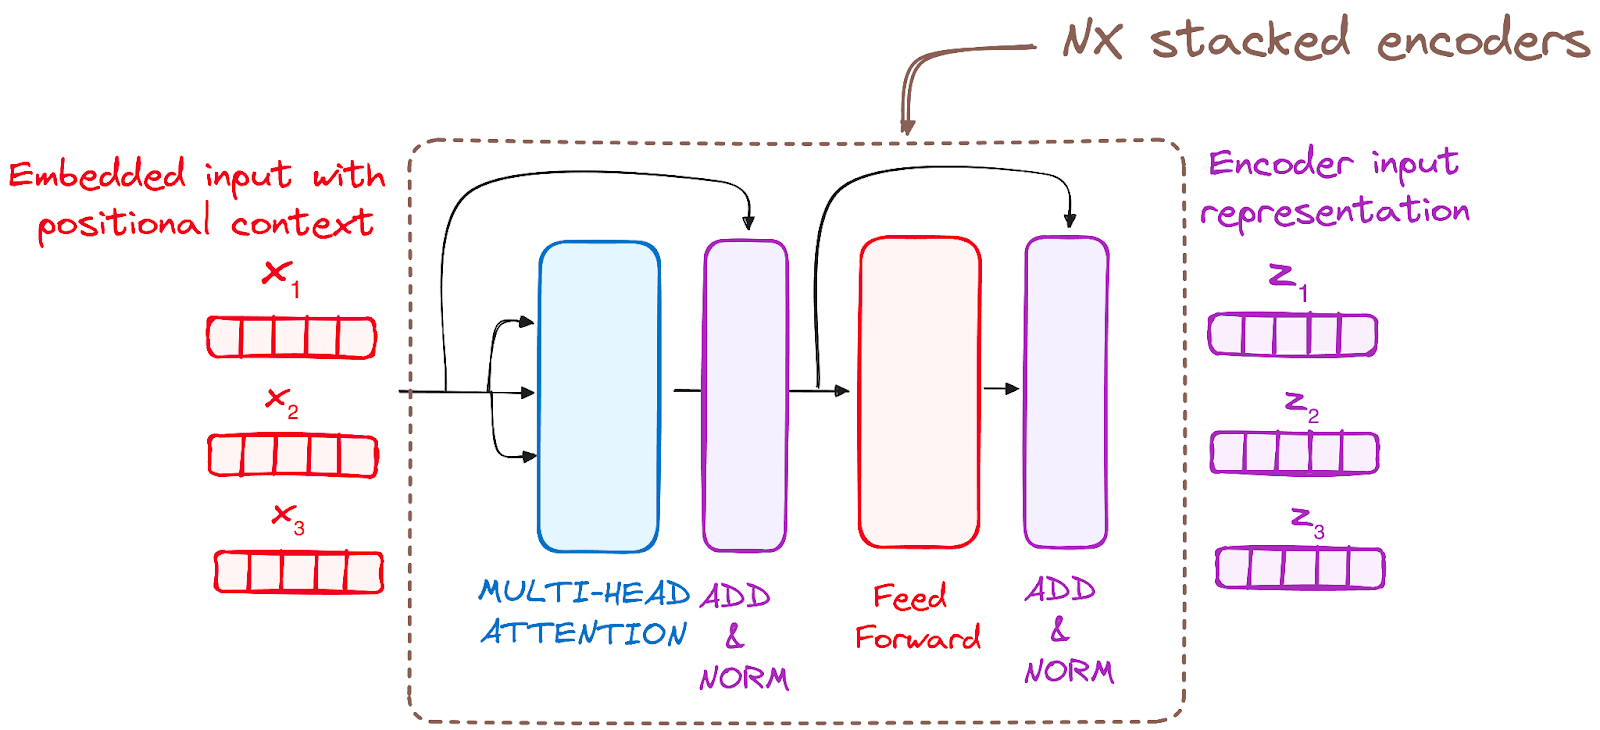


In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, self_attention_block:MultiHeadAttntionBlock, feed_forward_block:FeedForwardBlock, dropout:float ):
    super().__init__()
    self.self_attention_block=self_attention_block
    self.feed_forward_block=feed_forward_block

    self.residual_connections=nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])


  def forward(self, x, src_mask):
    x= self.residual_connections[0](x, lambda x: self.self_attention_block(x,x,x,src_mask))
    x= self.residual_connections[1](x, self.feed_forward_block)
    return x

In [ ]:
class Encoder(nn.Module):
  def __init__(self, layers:nn.ModuleList):
    super().__init()
    self.layers=layers
    self.norm = LayerNormalization()

  def forward(self, x, src_mask):
    for layer in self.layers:
      x=layer(x, src_mask)
    return self.norm(x)

###Decoder
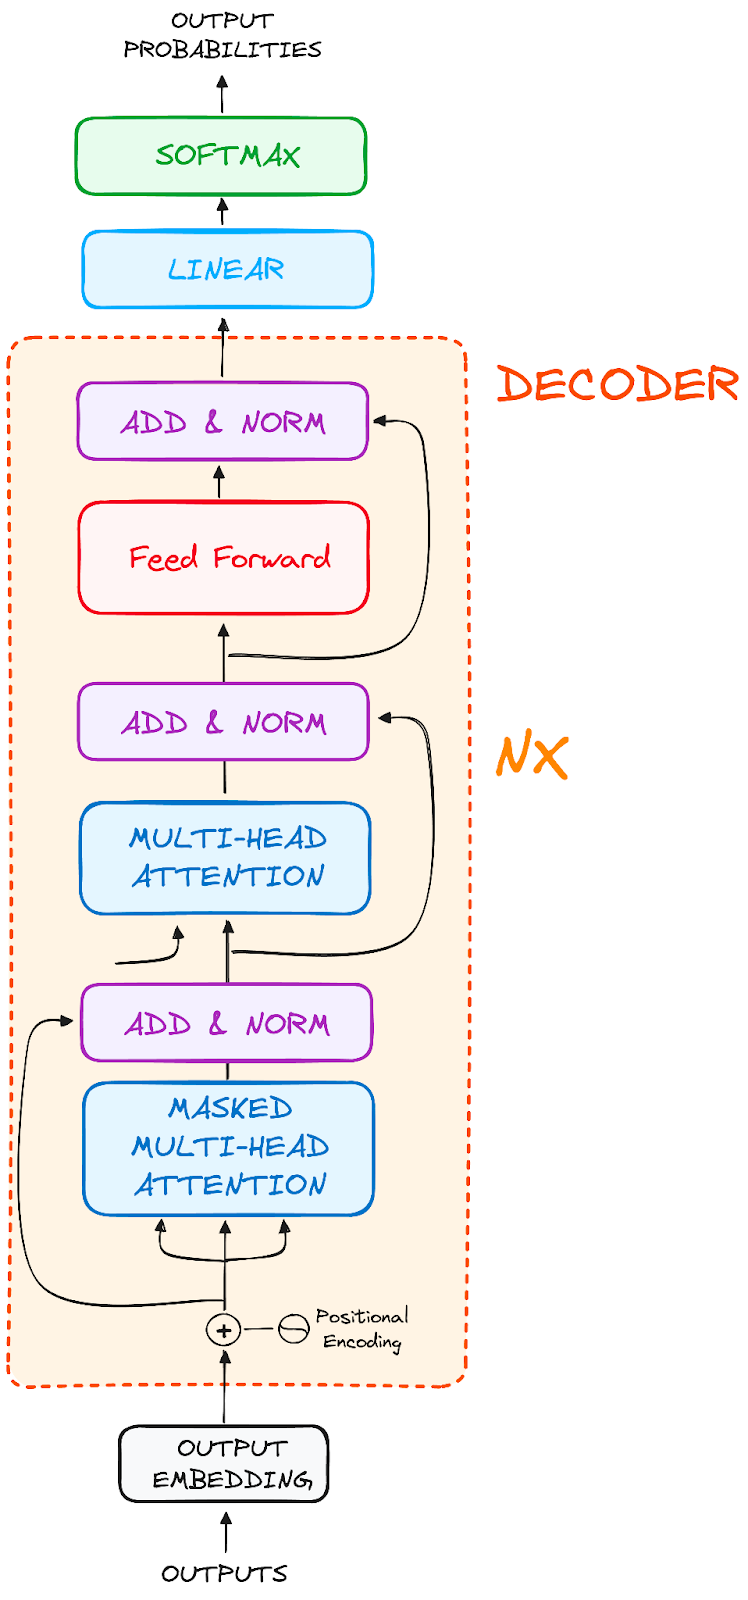

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, self_attention_block:MultiHeadAttntionBlock , cross_attention_block: MultiHeadAttntionBlock, feed_forward_block: FeedForwardBlock, dropout: float):
    super().__init__()
    self.self_attention_block = self_attention_block
    self.cross_attention_block = cross_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])

  def forward(self, x, encoder_output,src_mask, tgt_mask):
    x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
    x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
    x = self.residual_connections[2](x, self.feed_forward_block)
    return x

In [ ]:
class Decoder(nn.Module):
  def __init__(self, layers: nn.ModuleList) -> None:
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self, x, encoder_output, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, encoder_output, src_mask, tgt_mask)
    return self.norm(x)

###Projection Layer
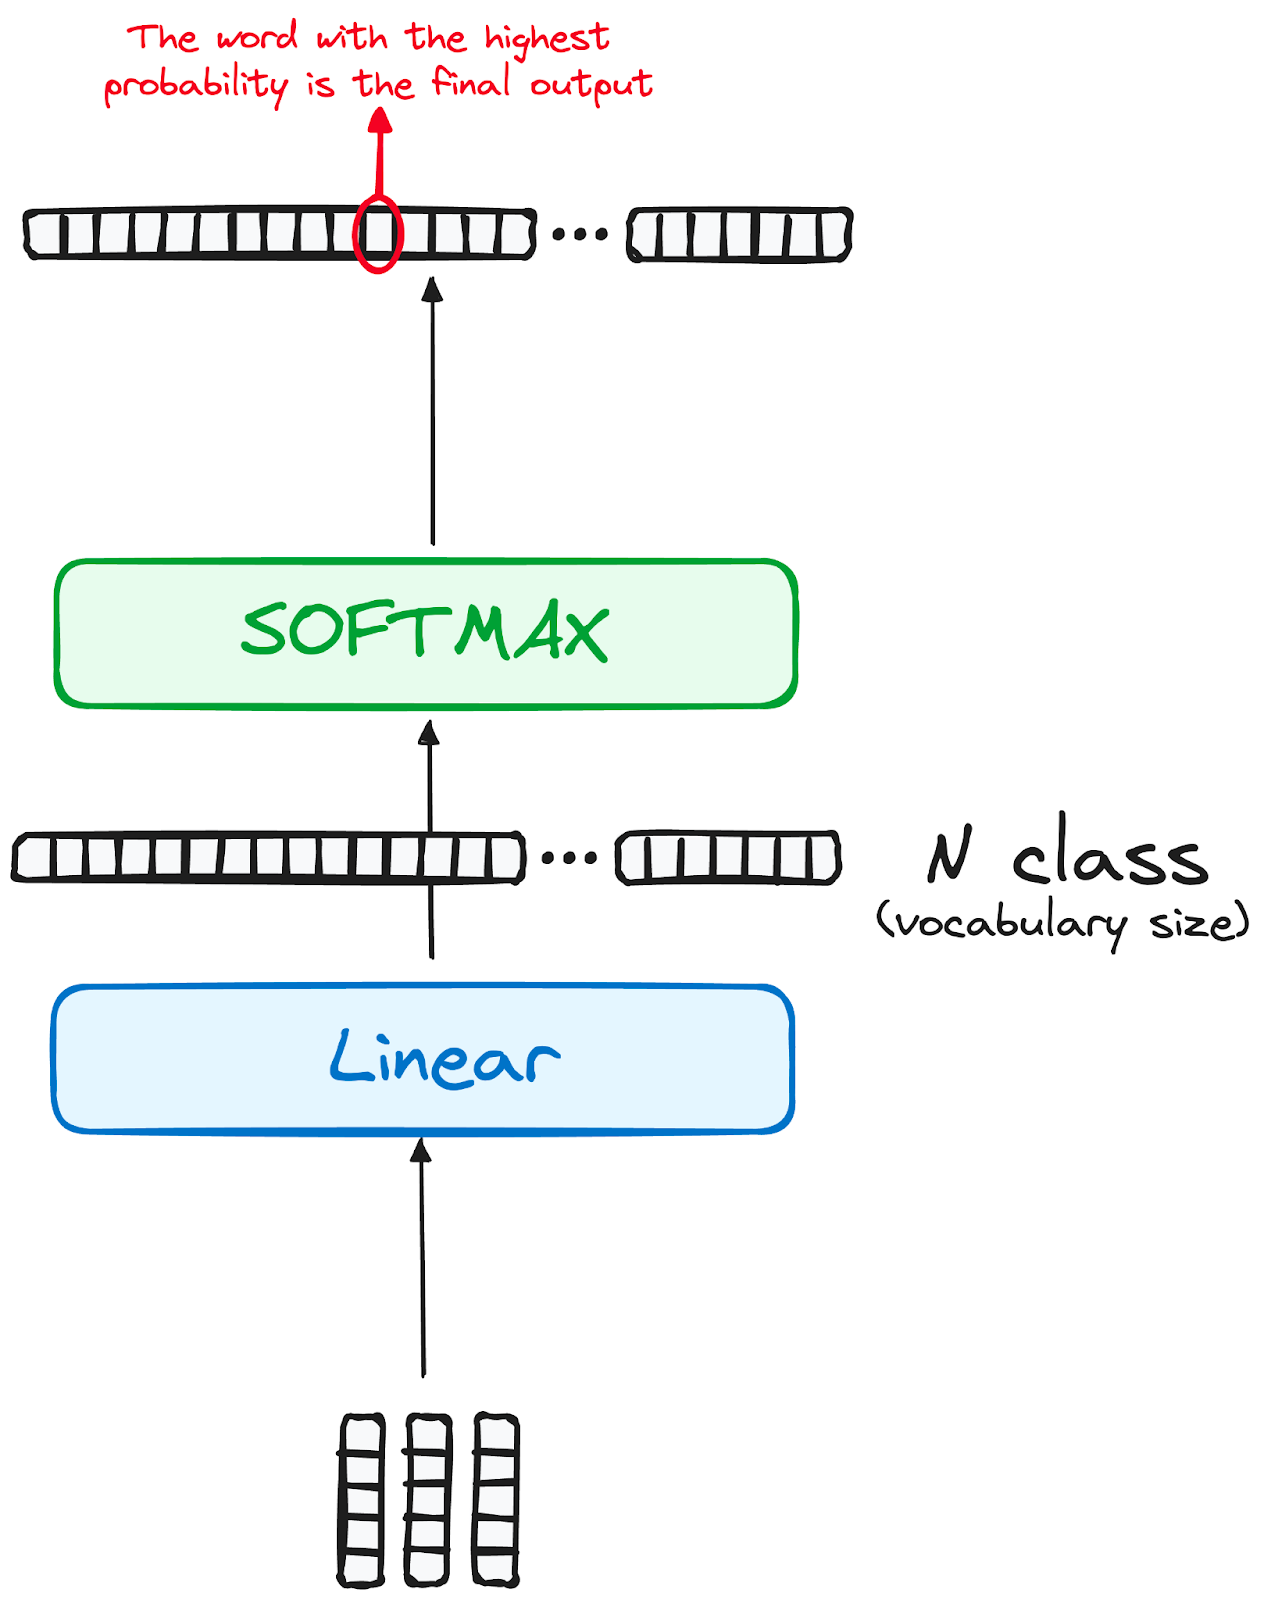

In [ ]:
class ProjectionLayer(nn.Module):
  def __init__(self, d_model, vocab_size):
    super().__init__()
    self.proj = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    return torch.log_softmax(self.proj(x), dim=-1)

#Model Development

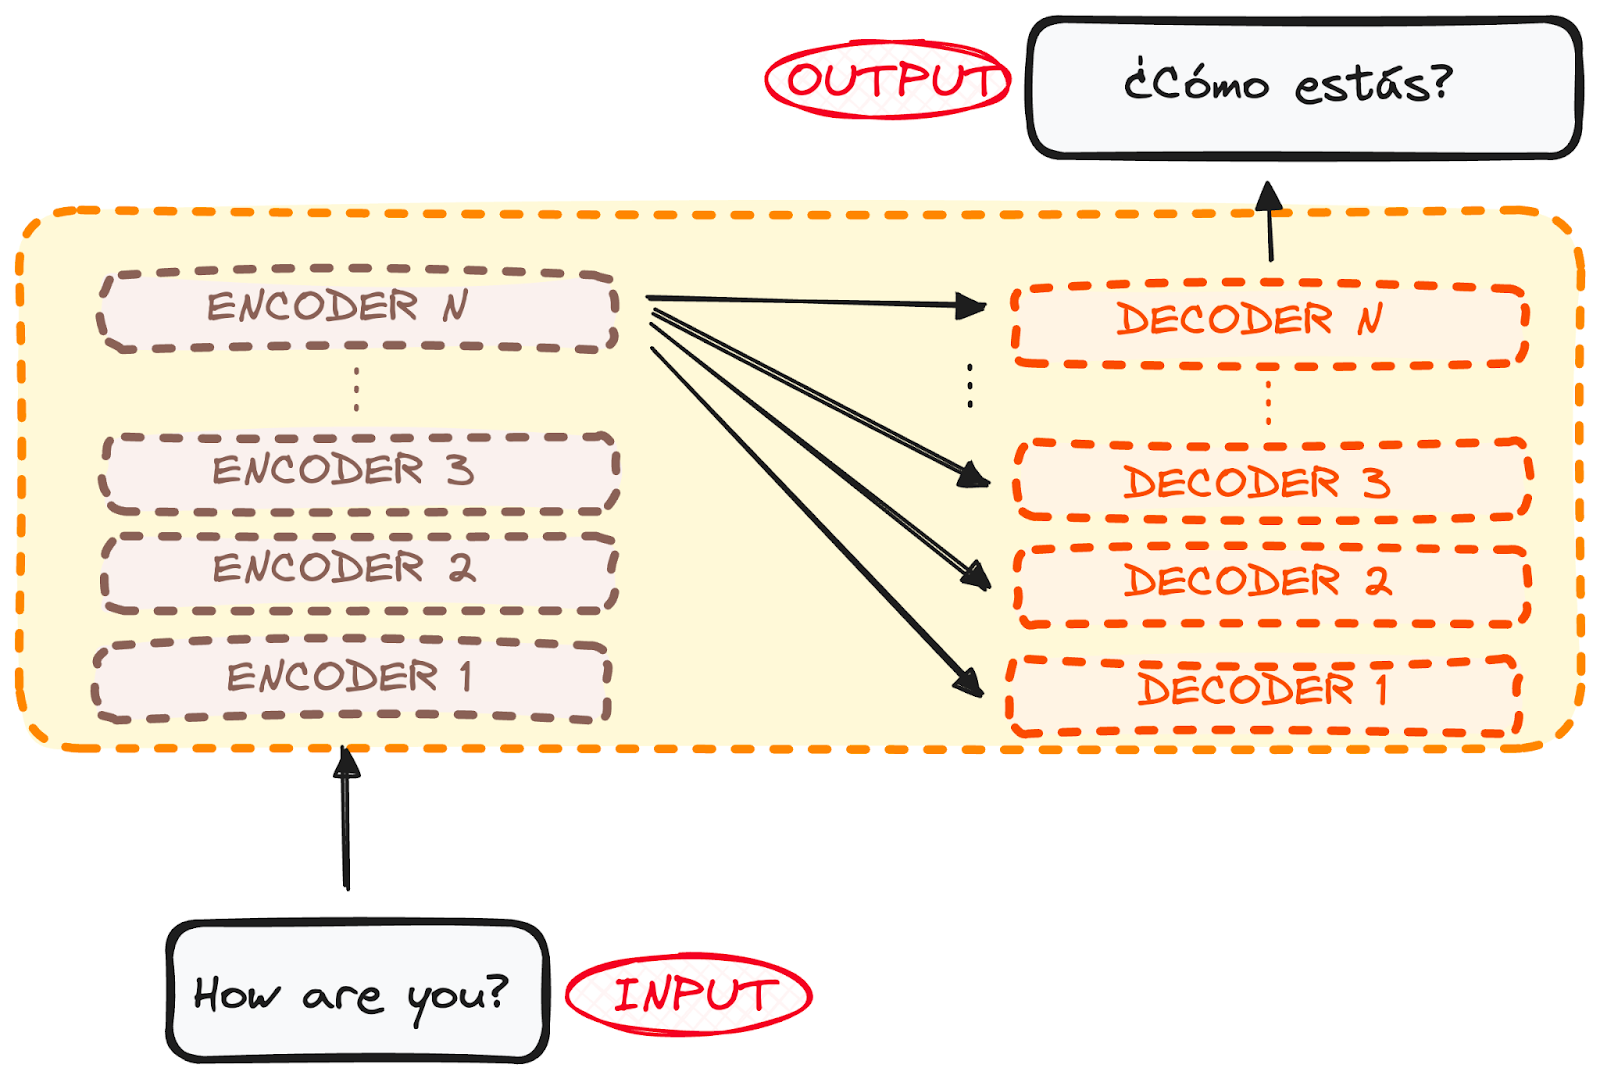

In [ ]:
class Transformer(nn.Module):
  def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbedding, tgt_embed: InputEmbedding, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.src_pos = src_pos
    self.tgt_pos = tgt_pos
    self.projection_layer = projection_layer

  def encode(self, src, src_mask):
    src = self.src_embed(src)
    src = self.src_pos(src)
    return self.encoder(src, src_mask)

  def decode(self, encoder_output,src_mask, tgt, tgt_mask):
    tgt = self.tgt_embed(tgt)
    tgt = self.tgt_pos(tgt)
    return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

  def project(self, x):
    return self.projection_layer(x)


In [ ]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, num_layers: int = 6, num_heads: int = 8, dropout: float=0.1, d_ff: int = 2048) -> Transformer:
  src_embed = InputEmbedding(d_model, src_vocab_size)
  tgt_embed = InputEmbedding(d_model, tgt_vocab_size)

  src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
  tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

  encoder_blocks = []
  for _ in range(num_layers):
   encoder_self_attention_block = MultiHeadAttntionBlock(d_model, num_heads, dropout)
   feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
   encoder_blocks.append(EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout))

  decoder_blocks = []
  for _ in range(num_layers):
    decoder_self_attention_block = MultiHeadAttntionBlock(d_model, num_heads, dropout)
    decoder_cross_attention_block = MultiHeadAttntionBlock(d_model, num_heads, dropout)
    feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
    decoder_blocks.append(DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout))

  encoder = Encoder(nn.ModuleList(encoder_blocks))
  decoder = Decoder(nn.ModuleList(decoder_blocks))

  projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

  transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

  for p in transformer.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

  return transformer

#Testing our Transformer

##Tokenization

In [ ]:
from torch.utils.data import Dataset,DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

#HuggingFace linraries
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

#pathlib
from pathlib import Path

#typing
from typing import Any


#Library for progress bars in loops
from tqdm import tqdm


#importing library of warnings
import warnings

In [ ]:
def build_tokenizer(config, ds, lang):
  # Crating a file path for the tokenizer
  tokenizer_path = Path(config['tokenizer_file'].format(lang))

  # Checking if Tokenizer already exists
  if not Path.exists(tokenizer_path):

      # If it doesn't exist, we create a new one
      tokenizer = Tokenizer(WordLevel(unk_token = '[UNK]')) # Initializing a new world-level tokenizer
      tokenizer.pre_tokenizer = Whitespace() # We will split the text into tokens based on whitespace

      # Creating a trainer for the new tokenizer
      trainer = WordLevelTrainer(special_tokens = ["[UNK]", "[PAD]",
                                                    "[SOS]", "[EOS]"], min_frequency = 2) # Defining Word Level strategy and special tokens

      # Training new tokenizer on sentences from the dataset and language specified
      tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer = trainer)
      tokenizer.save(str(tokenizer_path)) # Saving trained tokenizer to the file path specified at the beginning of the function
  else:
      tokenizer = Tokenizer.from_file(str(tokenizer_path)) # If the tokenizer already exist, we load it
  return tokenizer # Returns the loaded tokenizer or the trained tokenizer


##Load Dataset

In [65]:
# Iterating through dataset to extract the original sentence and its translation
def get_all_sentences(ds, lang):
    for pair in ds:
        yield pair['translation'][lang]


In [66]:
def get_ds(config):

    # Loading the train portion of the OpusBooks dataset.
    # The Language pairs will be defined in the 'config' dictionary we will build later
    ds_raw = load_dataset('opus_books', f'{config["lang_src"]}-{config["lang_tgt"]}', split = 'train')

    # Building or loading tokenizer for both the source and target languages
    tokenizer_src = build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = build_tokenizer(config, ds_raw, config['lang_tgt'])

    # Splitting the dataset for training and validation
    train_ds_size = int(0.9 * len(ds_raw)) # 90% for training
    val_ds_size = len(ds_raw) - train_ds_size # 10% for validation
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size]) # Randomly splitting the dataset

    # Processing data with the BilingualDataset class, which we will define below
    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    # Iterating over the entire dataset and printing the maximum length found in the sentences of both the source and target languages
    max_len_src = 0
    max_len_tgt = 0
    for pair in ds_raw:
        src_ids = tokenizer_src.encode(pair['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_src.encode(pair['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')

    # Creating dataloaders for the training and validadion sets
    # Dataloaders are used to iterate over the dataset in batches during training and validation
    train_dataloader = DataLoader(train_ds, batch_size = config['batch_size'], shuffle = True) # Batch size will be defined in the config dictionary
    val_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt # Returning the DataLoader objects and tokenizers


In [67]:
def casual_mask(size):
        # Creating a square matrix of dimensions 'size x size' filled with ones
        mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
        return mask == 0



In [68]:
class BilingualDataset(Dataset):

    # This takes in the dataset contaning sentence pairs, the tokenizers for target and source languages, and the strings of source and target languages
    # 'seq_len' defines the sequence length for both languages
    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len) -> None:
        super().__init__()

        self.seq_len = seq_len
        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)


    # Total number of instances in the dataset (some pairs are larger than others)
    def __len__(self):
        return len(self.ds)

    # Using the index to retrive source and target texts
    def __getitem__(self, index: Any) -> Any:
        src_target_pair = self.ds[index]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        # Tokenizing source and target texts
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Computing how many padding tokens need to be added to the tokenized texts
        # Source tokens
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2 # Subtracting the two '[EOS]' and '[SOS]' special tokens
        # Target tokens
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1 # Subtracting the '[SOS]' special token

        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')

        # Building the encoder input tensor by combining several elements
        encoder_input = torch.cat(
            [
            self.sos_token, # inserting the '[SOS]' token
            torch.tensor(enc_input_tokens, dtype = torch.int64), # Inserting the tokenized source text
            self.eos_token, # Inserting the '[EOS]' token
            torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )

        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]

        )

        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                self.eos_token, # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Adding padding tokens

            ]
        )

        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input,
            'encoder_mask': (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),
            'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & casual_mask(decoder_input.size(0)),
            'label': label,
            'src_text': src_text,
            'tgt_text': tgt_text
        }


##Validation Loop

In [69]:
# Define function to obtain the most probable next token
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    # Retrieving the indices from the start and end of sequences of the target tokens
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Computing the output of the encoder for the source sequence
    encoder_output = model.encode(source, source_mask)
    # Initializing the decoder input with the Start of Sentence token
    decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)

    # Looping until the 'max_len', maximum length, is reached
    while True:
        if decoder_input.size(1) == max_len:
            break

        # Building a mask for the decoder input
        decoder_mask = casual_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # Calculating the output of the decoder
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # Applying the projection layer to get the probabilities for the next token
        prob = model.project(out[:, -1])

        # Selecting token with the highest probability
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)

        # If the next token is an End of Sentence token, we finish the loop
        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0) # Sequence of tokens generated by the decoder


In [70]:
# Defining function to evaluate the model on the validation dataset
# num_examples = 2, two examples per run
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_state, writer, num_examples=2):
    model.eval() # Setting model to evaluation mode
    count = 0 # Initializing counter to keep track of how many examples have been processed

    console_width = 80 # Fixed witdh for printed messages

    # Creating evaluation loop
    with torch.no_grad(): # Ensuring that no gradients are computed during this process
        for batch in validation_ds:
            count += 1
            encoder_input = batch['encoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)

            # Ensuring that the batch_size of the validation set is 1
            assert encoder_input.size(0) ==  1, 'Batch size must be 1 for validation.'

            # Applying the 'greedy_decode' function to get the model's output for the source text of the input batch
            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            # Retrieving source and target texts from the batch
            source_text = batch['src_text'][0]
            target_text = batch['tgt_text'][0] # True translation
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy()) # Decoded, human-readable model output

            # Printing results
            print_msg('-'*console_width)
            print_msg(f'SOURCE: {source_text}')
            print_msg(f'TARGET: {target_text}')
            print_msg(f'PREDICTED: {model_out_text}')

            # After two examples, we break the loop
            if count == num_examples:
                break

##Training Loop

In [71]:
# We pass as parameters the config dictionary, the length of the vocabylary of the source language and the target language
def get_model(config, vocab_src_len, vocab_tgt_len):

    # Loading model using the 'build_transformer' function.
    # We will use the lengths of the source language and target language vocabularies, the 'seq_len', and the dimensionality of the embeddings
    model = build_transformer(vocab_src_len, vocab_tgt_len, config['seq_len'], config['seq_len'], config['d_model'])
    return model


In [72]:
# Define settings for building and training the transformer model
def get_config():
    return{
        'batch_size': 8,
        'num_epochs': 20,
        'lr': 10**-4,
        'seq_len': 350,
        'd_model': 512, # Dimensions of the embeddings in the Transformer. 512 like in the "Attention Is All You Need" paper.
        'lang_src': 'en',
        'lang_tgt': 'it',
        'model_folder': 'weights',
        'model_basename': 'tmodel_',
        'preload': None,
        'tokenizer_file': 'tokenizer_{0}.json',
        'experiment_name': 'runs/tmodel'
    }


# Function to construct the path for saving and retrieving model weights
def get_weights_file_path(config, epoch: str):
    model_folder = config['model_folder'] # Extracting model folder from the config
    model_basename = config['model_basename'] # Extracting the base name for model files
    model_filename = f"{model_basename}{epoch}.pt" # Building filename
    return str(Path('.')/ model_folder/ model_filename) # Combining current directory, the model folder, and the model filename



In [73]:
def train_model(config):
    # Setting up device to run on GPU to train faster
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device {device}")

    # Creating model directory to store weights
    Path(config['model_folder']).mkdir(parents=True, exist_ok=True)

    # Retrieving dataloaders and tokenizers for source and target languages using the 'get_ds' function
    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)

    # Initializing model on the GPU using the 'get_model' function
    model = get_model(config,tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])

    # Setting up the Adam optimizer with the specified learning rate from the '
    # config' dictionary plus an epsilon value
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps = 1e-9)

    # Initializing epoch and global step variables
    initial_epoch = 0
    global_step = 0

    # Checking if there is a pre-trained model to load
    # If true, loads it
    if config['preload']:
        model_filename = get_weights_file_path(config, config['preload'])
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename) # Loading model

        # Sets epoch to the saved in the state plus one, to resume from where it stopped
        initial_epoch = state['epoch'] + 1
        # Loading the optimizer state from the saved model
        optimizer.load_state_dict(state['optimizer_state_dict'])
        # Loading the global step state from the saved model
        global_step = state['global_step']

    # Initializing CrossEntropyLoss function for training
    # We ignore padding tokens when computing loss, as they are not relevant for the learning process
    # We also apply label_smoothing to prevent overfitting
    loss_fn = nn.CrossEntropyLoss(ignore_index = tokenizer_src.token_to_id('[PAD]'), label_smoothing = 0.1).to(device)

    # Initializing training loop

    # Iterating over each epoch from the 'initial_epoch' variable up to
    # the number of epochs informed in the config
    for epoch in range(initial_epoch, config['num_epochs']):

        # Initializing an iterator over the training dataloader
        # We also use tqdm to display a progress bar
        batch_iterator = tqdm(train_dataloader, desc = f'Processing epoch {epoch:02d}')

        # For each batch...
        for batch in batch_iterator:
            model.train() # Train the model

            # Loading input data and masks onto the GPU
            encoder_input = batch['encoder_input'].to(device)
            decoder_input = batch['decoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)

            # Running tensors through the Transformer
            encoder_output = model.encode(encoder_input, encoder_mask)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            proj_output = model.project(decoder_output)

            # Loading the target labels onto the GPU
            label = batch['label'].to(device)

            # Computing loss between model's output and true labels
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))

            # Updating progress bar
            batch_iterator.set_postfix({f"loss": f"{loss.item():6.3f}"})

            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # Performing backpropagation
            loss.backward()

            # Updating parameters based on the gradients
            optimizer.step()

            # Clearing the gradients to prepare for the next batch
            optimizer.zero_grad()

            global_step += 1 # Updating global step count

        # We run the 'run_validation' function at the end of each epoch
        # to evaluate model performance
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

        # Saving model
        model_filename = get_weights_file_path(config, f'{epoch:02d}')
        # Writting current model state to the 'model_filename'
        torch.save({
            'epoch': epoch, # Current epoch
            'model_state_dict': model.state_dict(),# Current model state
            'optimizer_state_dict': optimizer.state_dict(), # Current optimizer state
            'global_step': global_step # Current global step
        }, model_filename)


#Finaly Lets Train Our Model

In [ ]:
if __name__ == '__main__':
    warnings.filterwarnings('ignore') # Filtering warnings
    config = get_config() # Retrieving config settings
    train_model(config) # Training model with the config arguments